In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
train_stacks = ['CHATM2']
test_stacks = ['CHATM3']

In [5]:
stack_stain = {'CHATM2': 'F', 'CHATM3': 'F'}

# Number of sections on which to sample examples from.
stack_section_number = defaultdict(dict)

for name_u in all_known_structures:
    for st in train_stacks:
        stack_section_number[st][name_u] = 10
#         if name_u == '4N' or name_u == '10N':
#             stack_section_number[st][name_u] = 20
#         else:
#             stack_section_number[st][name_u] = 10
    for st in test_stacks:
        stack_section_number[st][name_u] = 10

stack_section_number.default_factory = None

In [6]:
win_id = 7

In [7]:
grid_indices_lookup_allStacks = {}

for stack in train_stacks + test_stacks:
    try:
#         grid_indices_lookup_allStacks[stack] = \
#         DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                            by_human=False, timestamp='latest',
#                                                            detector_id_f=1,
#                                                           return_locations=True)            

        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=True, timestamp='latest',
                                                          return_locations=True, suffix='structures')            

    except Exception as e:
        print e
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM2" "/home/yuncong/CSHL_labelings_v3/CHATM2" --exclude "*" --include "*win7*grid_indices_lookup*"
0
latest timestamp:  05102018101342
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM3" "/home/yuncong/CSHL_labelings_v3/CHATM3" --exclude "*" --include "*win7*grid_indices_lookup*"
0
latest timestamp:  04272018015834


In [8]:
from itertools import chain
all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) 
                                                 for st in train_stacks + test_stacks))))

In [9]:
def sample_addresses(stacks, structure):
        
    positive_labels = [structure]
    negative_labels = get_negative_labels(structure, 'neg_has_all_surround', 
                                          margin='500um', labels_found=all_labels)

    positive_addresses_all_stacks = {}
    negative_addresses_all_stacks = {}
        
    for stack in stacks:

        candidate_sections = list(chain(*[grid_indices_lookup_allStacks[stack][pl].dropna(how='any').index.tolist() 
                                      for pl in positive_labels]))

        n_sections = stack_section_number[stack][structure]

        if stack_stain[stack] == 'F':
            neurotrace_sections = []
            nissl_sections = []
            for sec in candidate_sections:
                if (metadata_cache['sections_to_filenames'][stack][sec].split('-')[1][0] == 'F') \
                or stack in ['CHATM2', 'CHATM3']:
                    neurotrace_sections.append(sec)
                else:
                    nissl_sections.append(sec)
            print 'neurotrace_sections', neurotrace_sections
            print 'nissl_sections', nissl_sections
            sampled_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_sections), replace=False)
        else:
            sampled_sections = np.random.choice(candidate_sections, min(len(candidate_sections), n_sections), replace=False)
            
        positive_addresses_all_stacks[stack] = sorted([(stack, sec, tuple(loc))
for nl in set(positive_labels) & set(grid_indices_lookup_allStacks[stack].columns)
  for sec, locs in grid_indices_lookup_allStacks[stack][nl].loc[sampled_sections].dropna().iteritems()
  for loc in locs])

        negative_addresses_all_stacks[stack] = sorted([(stack, sec, tuple(loc))
for nl in set(negative_labels) & set(grid_indices_lookup_allStacks[stack].columns)
  for sec, locs in grid_indices_lookup_allStacks[stack][nl].loc[sampled_sections].dropna().iteritems()
  for loc in locs])

    positive_addresses = sum(positive_addresses_all_stacks.values(), [])
    negative_addresses = sum(negative_addresses_all_stacks.values(), [])

    del positive_addresses_all_stacks, negative_addresses_all_stacks

    return positive_addresses, negative_addresses

In [10]:
# train_scheme = 'stretch_min_max'
# train_scheme = 'normalize_mu_sigma_global_(-1,5)'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
train_scheme = 'none'

# test_scheme = 'stretch_min_max'
# test_scheme = 'normalize_mu_sigma_global_(-1,5)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
test_scheme = 'none'

In [11]:
# existing_classifier_id = 998 # If set, not train from scratch
# existing_classifier_id = 990
# extract_train_features = True

In [12]:
existing_classifier_id = None
extract_train_features = True
# classifier_id = 990 # MD585/MD589 -> MD594, cnn
# classifier_id = 991 # MD585/MD589 -> MD594, lbp
# classifier_id = 992 # MD585/MD589 -> MD594, glcm
# classifier_id = 993 # MD585/MD589 -> MD594, mean greylevel
classifier_id = 899 # CHATM2 -> CHATM2, cnn

In [13]:
# method = 'mean_intensity'
method = 'cnn'

neurotrace_sections [157, 158, 159, 160, 161, 197, 199, 201]
nissl_sections []
# positive train = 23
# negative train = 5088
('CHATM2', 158)
('CHATM2', 201)
('CHATM2', 159)
('CHATM2', 197)
('CHATM2', 199)
('CHATM2', 160)
('CHATM2', 161)
('CHATM2', 157)
neurotrace_sections [204, 205, 206, 207, 208, 245, 247]
nissl_sections []
# positive test = 17
# negative test = 4359
('CHATM3', 207)
('CHATM3', 206)
('CHATM3', 208)
('CHATM3', 205)
('CHATM3', 247)
('CHATM3', 204)
('CHATM3', 245)
Training: 23 positive, 23 negative
Test: 17 positive, 1000 negative
aws s3 cp "/data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump"


Fitting classifier: 0.00 seconds


0
Training: 23 positive, 23 negative
Test: 17 positive, 1000 negative
aws s3 cp "/data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump"


Fitting classifier: 0.00 seconds


0
Training: 23 positive, 23 negative
Test: 17 positive, 1000 negative
aws s3 cp "/data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump"


Fitting classifier: 0.00 seconds


0
Training: 23 positive, 23 negative
Test: 17 positive, 1000 negative
aws s3 cp "/data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump"


Fitting classifier: 0.00 seconds


0
Training: 23 positive, 23 negative
Test: 17 positive, 1000 negative
aws s3 cp "/data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump"


Fitting classifier: 0.00 seconds


0
Training: 23 positive, 23 negative
Test: 17 positive, 1000 negative
aws s3 cp "/data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump" "s3://mousebrainatlas-data/CSHL_classifiers/setting_899/classifiers/6N_clf_setting_899.dump"


Fitting classifier: 0.00 seconds


0


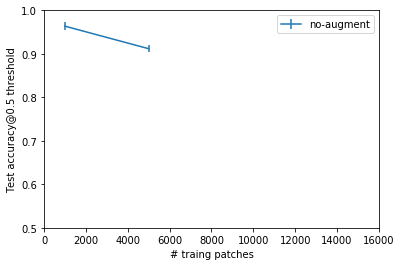

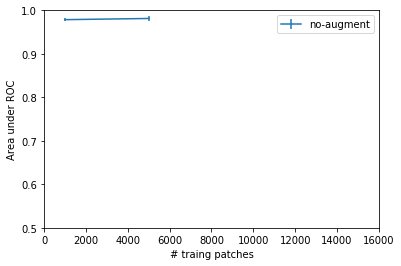

No handlers could be found for logger "matplotlib.legend"


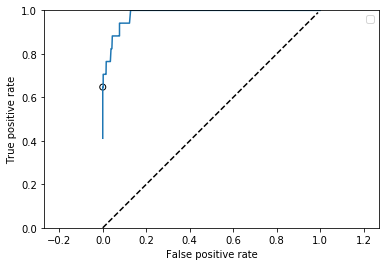

In [14]:
# for structure in all_known_structures:
for structure in ['6N']:

    # features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}
    features_dict = defaultdict(dict)

    ############## Sample and Load training feature vectors #########################################

    if extract_train_features:
    
        positive_addresses_traindata, negative_addresses_traindata = \
        sample_addresses(train_stacks, structure)

        print '# positive train =', len(positive_addresses_traindata)
        print '# negative train =', len(negative_addresses_traindata)

        addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

        for variant in [0]:
            features_loaded = read_features(addresses=addresses_to_compute, 
                                            scheme=train_scheme, win_id=7, prep_id=2, 
                                            model=model, mean_img=mean_img, model_name=model_name, 
                                            batch_size=batch_size,
                                           method=method,
                                           compute_new_addresses=True
#                                            compute_new_addresses=False
                                           )
            
            for addr, f in izip(addresses_to_compute, features_loaded):
                if f is not None:
                    features_dict[(train_scheme, variant)][addr] = f

            del features_loaded

    ############## Sample and Load test feature vectors #############################################
    
    positive_addresses_testdata, negative_addresses_testdata = \
    sample_addresses(test_stacks, structure)
    
    print '# positive test =', len(positive_addresses_testdata)
    print '# negative test =', len(negative_addresses_testdata)
    
    addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

    for variant in [0]:
        features_loaded = read_features(addresses=addresses_to_compute, 
                                        scheme=test_scheme, win_id=7, prep_id=2, 
                                        model=model, mean_img=mean_img, model_name=model_name, 
                                        batch_size=batch_size,
                                           method=method,
                                       compute_new_addresses=True
#                                         compute_new_addresses=False
                                       )

        for addr, f in izip(addresses_to_compute, features_loaded):
            if f is not None:
                features_dict[(test_scheme, variant)][addr] = f

        del features_loaded
            
    ########################################################################################
    
    # n_train_list = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]
#     n_train_list = [10, 1000]
#     n_train_list = [1000, 5000, 15000]
    n_train_list = [1000, 5000]
#     n_train_list = [15000]
    test_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))
    train_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))

    for n_train in n_train_list:

        for trial in range(3):
            
            ##### Sample from training pool the required number of examples ######

            # If train and test data are from different sets
            n_train_pos = min(n_train, len(positive_addresses_traindata))
#             if len(positive_addresses_traindata) < n_train_pos:
#                 continue
            training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
            
            n_test_pos = min(len(positive_addresses_testdata), 1000)
            test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)), n_test_pos, replace=False)

            # If train and test are from same set
        #     n_pos_total = len(positive_addresses)
        #     n_train_pos = 1000
        #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
        #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_pos = len(test_pos_indices)

            # If train and test data are from different sets
            n_train_neg = n_train_pos
            training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
            
            n_test_neg = min(len(negative_addresses_testdata), 1000)
            test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)), n_test_neg, replace=False)

            # If train and test are from same set
        #     n_neg_total = len(negative_addresses)
        #     n_train_neg = 1000
        #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
        #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_neg = len(test_neg_indices)

            print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
            print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

            ################

            if extract_train_features:
                # If train and test data are from different sets
                addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
                addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]

            addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
            addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

            #################

#             for augment_training in [True, False]:
            for augment_training in [False]:
        
                feature_classifier_alg = 'lr'
#                 feature_classifier_alg = 'xgb2'
        #             feature_classifier_alg = 'lin_svc'
        #             feature_classifier_alg = 'lin_svc_calib'
                sample_weights = None   

                if extract_train_features:
            
                    if augment_training:
                        train_transforms = range(8)
                    else:
                        train_transforms = range(1)
                    features_train_pos = {(train_scheme, tf_variant): 
                                          [features_dict[(train_scheme, tf_variant)][addr] 
                                           for addr in addresses_train_pos 
                                           if addr in features_dict[(train_scheme, tf_variant)]]
                                              for tf_variant in train_transforms}
                    features_train_neg = {(train_scheme, tf_variant): 
                                          [features_dict[(train_scheme, tf_variant)][addr] 
                                           for addr in addresses_train_neg
                                           if addr in features_dict[(train_scheme, tf_variant)]]
                                              for tf_variant in train_transforms}

                    train_data = np.concatenate([np.r_[features_train_pos[(train_scheme,tf)], 
                                                       features_train_neg[(train_scheme,tf)]] 
                                                    for tf in train_transforms])
                    train_labels = np.concatenate([np.r_[np.ones((len(features_train_pos[(train_scheme,tf)]), )), 
                                                        -np.ones((len(features_train_neg[(train_scheme,tf)]), ))]
                                                  for tf in train_transforms])

                if existing_classifier_id is None:
                    clf = train_binary_classifier(train_data, train_labels,
                                       alg=feature_classifier_alg, 
                                       sample_weights=sample_weights)

    #                 del train_data, features_train_pos, features_train_neg

                    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
                    create_parent_dir_if_not_exists(clf_fp)
                    joblib.dump(clf, clf_fp)
                    upload_to_s3(clf_fp)
                else:
                    sys.stderr.write('Load existing classifiers %d\n' % existing_classifier_id)
                    clf = DataManager.load_classifiers(classifier_id=existing_classifier_id)[structure]
                
                ######################### Compute train metrics #########################
                
                if extract_train_features:
                    train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
                    train_metrics_all_ntrain[n_train][(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics)
                
                ######################### Test ###############################
                
                test_transforms = range(1)
                features_test_pos = {(test_scheme, tf_variant): 
                                      [features_dict[(test_scheme, tf_variant)][addr] 
                                       for addr in addresses_test_pos
                                      if addr in features_dict[(test_scheme, tf_variant)]]
                                          for tf_variant in test_transforms}
                features_test_neg = {(test_scheme, tf_variant): 
                                      [features_dict[(test_scheme, tf_variant)][addr] 
                                       for addr in addresses_test_neg
                                      if addr in features_dict[(test_scheme, tf_variant)]]
                                          for tf_variant in test_transforms}
                
                test_data = np.concatenate([np.r_[features_test_pos[(test_scheme,tf_variant)], 
                                  features_test_neg[(test_scheme,tf_variant)]]
                                            for tf_variant in train_transforms])
                test_labels = np.concatenate([np.r_[np.ones((len(features_test_pos[(test_scheme,tf_variant)]), )), 
                                     -np.ones((len(features_test_neg[(test_scheme,tf_variant)]), ))]
                                            for tf_variant in train_transforms])
                test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
    #             print "acc@0.5 = %.3f, acc@opt = %.3f, opt_thresh = %.3f, auroc = %.3f, auprc = %.3f" % \
    #             (test_metrics['acc'][0.5], test_metrics['acc'][test_metrics['opt_thresh']], test_metrics['opt_thresh'], test_metrics['auroc'], test_metrics['auprc'])

                test_metrics_all_ntrain[n_train][(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics)

    train_metrics_all_ntrain.default_factory = None
    test_metrics_all_ntrain.default_factory = None
    
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');

    plot_roc_curve(test_metrics_all_ntrain[1000][(test_scheme,
                  'no-augment')][0]['fp'], 
                   test_metrics_all_ntrain[1000][(test_scheme,
                  'no-augment')][0]['tp'], 
                  test_metrics_all_ntrain[1000][(test_scheme,
                  'no-augment')][0]['opt_thresh']);
    
    import uuid

    result = {
        'n_sections': stack_section_number,
        'stain': stack_stain,
        'train_stacks': train_stacks,
        'test_stacks': test_stacks,
        'test_scheme': test_scheme,
        'train_scheme': train_scheme,
        'train_metrics_all_ntrain': train_metrics_all_ntrain,
        'test_metrics_all_ntrain': test_metrics_all_ntrain,
        'structure': structure,
        'method': method,
        'classifier_id': existing_classifier_id if existing_classifier_id is not None else classifier_id
    }

#     create_if_not_exists(ROOT_DIR + '/assessment_results_v3/')
#     save_pickle(result, ROOT_DIR + '/assessment_results_v3/assessment_result_%s.pkl' % str(uuid.uuid1()).split('-')[0])

In [17]:
np.mean(extract_one_metric(test_metrics_all_ntrain, 'auroc')[15000][('normalize_mu_region_sigma_wholeImage_(-1,5)','no-augment')])

0.8676170000000001

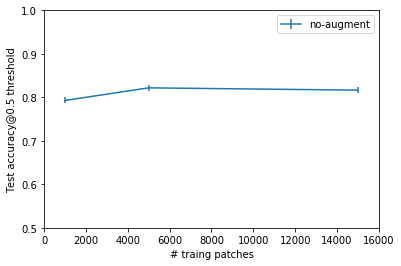

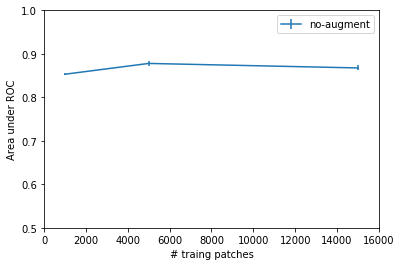

In [18]:
plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');